In [8]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim

In [9]:
def gen_sample(batch_size, N_agents, in_dim = None, L = None):
    """ 
        generates an inital states in [0,L1] x [0,L2] x ... x [0, Ln] of shape [Batch_size, in_dim]
    """
    #### Region with pdf > 0
    if in_dim is None and L is None:
        raise ValueError("Need either L or in dim to be set")
    if in_dim is None:
        in_dim = len(L)
    if L is None:
        L = [1. for _ in range(in_dim)]
    x = torch.rand(batch_size, N_agents, in_dim).abs()
    for i in range(len(L)):
        x[:, :, i] = torch.clamp(x[:, :, i],min = 0.6, max=0.9)
    return x


In [10]:
N_Agents = 1
in_dim = 1
batch_size = 256
n_samples = 2048
timesteps = 30
lam = 0.5
k_max = 4
control_energy_reg = 0#1e-6 ### regularization on maximum control energy
u_max = 100 # does not do anything currently
thres = 0#1e-2 ### softness on constraint (will penalize when this much outside of rect)
dropout = 0


In [11]:
densties = ['custom']
regions = [
        torch.tensor([[.0, .3]]),
        torch.tensor([[.6, .9]])
        ]
weights = [.5, .5]

In [12]:
def custom_pdf(x):
    """
     Define a custom probability density function (PDF).
    """
    #x = x.item()
    #return np.where(((x > 0) & (x < 1)), 1, 0)
    #return np.where(((x > 0) & (x < 0.3)) | ((x > 0.6) & (x < 0.9)), 5 / 3, 0)
    return np.where((x > 0.6) & (x < 0.9),3, 0)

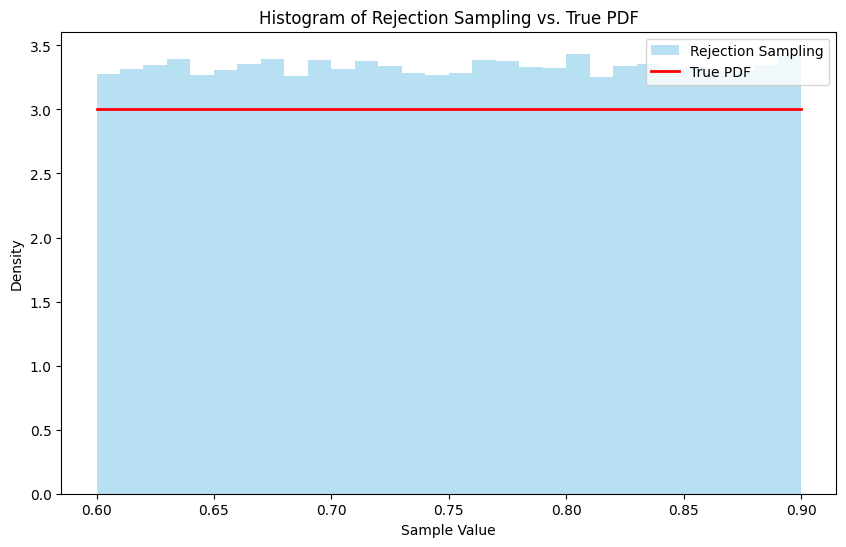

tensor([ 1.0000, -0.9639,  0.0013,  0.6974]) target distribution


In [13]:
import Ergodic_Loss
import Recursive_KAN
import sys
sys.path.append(r'C:\Users\JP\Documents\TU Berlin\Master\Code_RNN\Recursive_kan\Ergodic_Loss.py') 
sys.path.append(r'C:\Users\JP\Documents\TU Berlin\Master\Code_RNN\Recursive_kan\Recursive_KAN.py') 
import importlib
importlib.reload(Ergodic_Loss)
importlib.reload(Recursive_KAN)
criterion = Ergodic_Loss.Ergodicity_Loss(N_Agents = N_Agents, n_timesteps = timesteps,L = None, in_dim = in_dim, k_max = k_max, thres = thres, control_energy_reg = control_energy_reg, density = 'custom',verbose = False, pdf = custom_pdf, max_pdf = 5/3, num_samples = 100000)
model = Recursive_KAN.KAN_RNN_Layer(N_Agents = N_Agents, in_dim = in_dim, hidden = 128, depth = 2, n_timesteps = timesteps,sys_param_lam= lam, u_max = u_max, network_type='multi', dropout = dropout)
model.init_hidden(batch_size = batch_size)

In [14]:
optimizer_lbfgs = optim.LBFGS(model.parameters(), line_search_fn = 'strong_wolfe')


In [15]:
import time
criterion.verbose = False
epochs = 50  # Number of epochs to train
train_loss = []
test_loss = []
model.train()  # Set the model to training mode
show = True
for epoch in range(epochs):
    running_loss = 0.0 
    for samples in range(n_samples // batch_size):
        start_time = time.time()
        inputs = gen_sample(batch_size = batch_size, N_agents = N_Agents, in_dim = in_dim)
        def closure():
            model.init_hidden(batch_size = batch_size)
            optimizer_lbfgs.zero_grad()
            control , outputs = model(inputs)
            loss = criterion(x = outputs, u = control) + model.penalty
            loss.backward()
            return loss
        optimizer_lbfgs.step(closure)
        with torch.no_grad():
            model.init_hidden(batch_size = batch_size)
            control , outputs = model(gen_sample(batch_size = batch_size, N_agents = N_Agents, in_dim = in_dim))
            loss = criterion(x = outputs, u = control) + model.penalty
        running_loss += loss.item()
        if show:
            show = False
            criterion.verbose = False
            print("per iter:", time.time()- start_time,"total time:" , (time.time()- start_time) * (n_samples / batch_size) * epochs)
    
    avg_loss = running_loss / (n_samples // batch_size)
    train_loss.append(avg_loss)
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.6f}")
plt.plot(train_loss)
plt.title(f'train_loss uniform distribution with system dynamic x(k + 1) = x(k) + {lam} u')
plt.legend()
plt.show()
print("Training Complete!")

per iter: 13.020934343338013 total time: 5208.373737335205
Epoch [1/50], Loss: 1.586515
Epoch [2/50], Loss: 0.377109
Epoch [3/50], Loss: 0.348092
Epoch [4/50], Loss: 0.335552
Epoch [5/50], Loss: 0.329662
Epoch [6/50], Loss: 0.322077
Epoch [7/50], Loss: 0.314221
Epoch [8/50], Loss: 0.314506
Epoch [9/50], Loss: 0.314476
Epoch [10/50], Loss: 0.312801
Epoch [11/50], Loss: 0.301940
Epoch [12/50], Loss: 0.294386
Epoch [13/50], Loss: 0.291174
Epoch [14/50], Loss: 0.289891
Epoch [15/50], Loss: 0.286804
Epoch [16/50], Loss: 0.285567
Epoch [17/50], Loss: 0.283659
Epoch [18/50], Loss: 0.283628
Epoch [19/50], Loss: 0.280986
Epoch [20/50], Loss: 0.282132
Epoch [21/50], Loss: 0.279994
Epoch [22/50], Loss: 0.279410
Epoch [23/50], Loss: 0.278560
Epoch [24/50], Loss: 0.277612


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


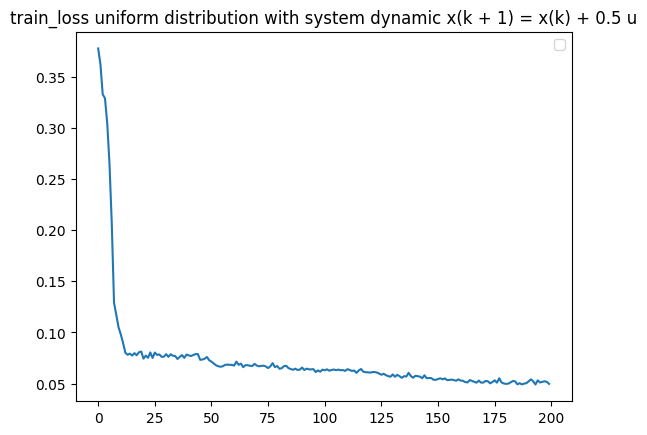

Training Complete!


In [ ]:
plt.plot(train_loss[-300:])
plt.title(f'train_loss uniform distribution with system dynamic x(k + 1) = x(k) + {lam} u')
plt.legend()
plt.show()
print("Training Complete!")

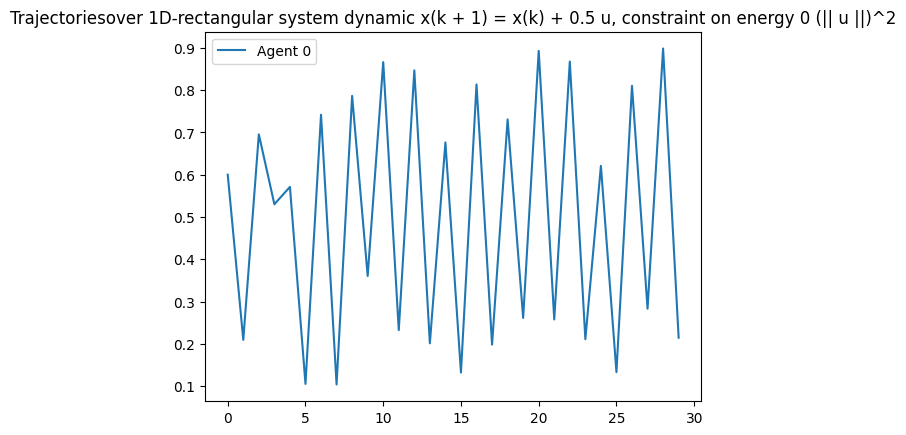

In [ ]:
#plot trajectory
#model.eval()
inital_state = gen_sample(batch_size = 1, N_agents = N_Agents, in_dim = in_dim)
model.init_hidden(batch_size = 1)
outs, control = model(inital_state)
for j in range(N_Agents):
    plt.plot(outs[:,:,j,:].squeeze().detach(), label = f'Agent {j}')
plt.title(f'Trajectoriesover 1D-rectangular system dynamic x(k + 1) = x(k) + {lam} u, constraint on energy {control_energy_reg} (|| u ||)^2')
plt.legend()
plt.show()



In [ ]:
#import Ergodic_Loss
#import sys
#sys.path.append(r'C:\Users\JP\Documents\TU Berlin\Master\Code_RNN\Recursive_kan\Ergodic_Loss.py') 
#import importlib
#importlib.reload(Ergodic_Loss)
#criterion = Ergodic_Loss.Ergodicity_Loss(N_Agents = N_Agents, n_timesteps = timesteps,L = None, in_dim = in_dim, k_max = k_max,control_energy_reg = control_energy_reg, density = 'custom', pdf = custom_pdf, max_pdf = 5 / 3, num_samples = 100000)
inital_state = gen_sample(batch_size = 1, N_agents = N_Agents, in_dim = in_dim)
model.init_hidden(batch_size = 1)
outs, control = model(inital_state)
criterion.verbose = True
criterion(x = outs, u = control)

tensor(0.2229, grad_fn=<DivBackward0>)
tensor([[ 0.0000,  1.0116,  0.3431, -0.4281]], grad_fn=<SubBackward0>) difference
tensor([[ 0.0000,  1.0116,  0.3431, -0.4281]], grad_fn=<SubBackward0>)
model tensor([[0.0000, 0.0469, 0.0930, 0.0325]], grad_fn=<MulBackward0>) target tensor([ 0.0000e+00, -9.6471e-01,  8.4472e-04,  8.4283e-02])
scaling tensor([0.0000, 1.0000, 0.2685, 0.1210]) tensor([0.0000, 1.0000, 0.2685, 0.1210])


tensor(0.2889, grad_fn=<AddBackward0>)

In [ ]:
inital_state = gen_sample(batch_size = 1, N_agents = N_Agents, in_dim = in_dim)
model.init_hidden(batch_size = 1)
outs, control = model(inital_state)
criterion(x = outs, u = control)

tensor(0.4357, grad_fn=<DivBackward0>)
tensor([[0.0000, 2.2917, 1.1056, 0.0884]], grad_fn=<SubBackward0>) difference
tensor([[0.0000, 2.2917, 1.1056, 0.0884]], grad_fn=<SubBackward0>)
model tensor([[0.0000, 1.3298, 0.2959, 0.0956]], grad_fn=<MulBackward0>) target tensor([ 0.0000, -0.9619, -0.0010,  0.0849])
scaling tensor([0.0000, 1.0000, 0.2685, 0.1210]) tensor([0.0000, 1.0000, 0.2685, 0.1210])


tensor(0.6498, grad_fn=<AddBackward0>)